## Gaussian classifier code

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import tabula
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
pd.options.display.max_rows = 999

%load_ext autoreload
%autoreload 2

In [6]:
# Read pdf into DataFrame
full_df = tabula.read_pdf("Data/ONET_Data/future-of-employment.pdf", pages=62, area = (262.80, 109.44, 749.52, 510.48), stream=True) #61-77'
for n in range(63,78):
    df = tabula.read_pdf("Data/ONET_Data/future-of-employment.pdf", pages=str(n),area = (127.44, 109.44, 749.52, 510.48), stream=True) 
    full_df = full_df.append(df, ignore_index = True, sort=True) 
full_df = full_df.drop(full_df[full_df['Probability'].isnull()].index)
full_df = full_df.rename(columns = {'soc code': 'soc_code'})
full_df2 = full_df[["soc_code", "Label", "Probability", "Occupation"]]
print("Column headings:")
print(full_df2.columns)

Column headings:
Index(['soc_code', 'Label', 'Probability', 'Occupation'], dtype='object')


In [7]:
#Import excel files
variables_df = pd.read_excel('Data/ONET_Data/Abilities.xlsx', sheet_name='Abilities')
df2 = pd.read_excel('Data/ONET_Data/Skills.xlsx', sheet_name='Skills')
df3 = pd.read_excel('Data/ONET_Data/Work Context.xlsx', sheet_name='Work Context')
df4 = pd.read_excel('Data/ONET_Data/Knowledge.xlsx', sheet_name='Knowledge')
df5 = pd.read_excel('Data/ONET_Data/Work Activities.xlsx', sheet_name='Work Activities')
variables_df = variables_df.append(df2, ignore_index = True, sort=True) 
variables_df = variables_df.append(df3, ignore_index = True, sort=True) 
variables_df = variables_df.append(df4, ignore_index = True, sort=True) 
variables_df = variables_df.append(df5, ignore_index = True, sort=True) 
variables_df = variables_df.rename(columns = {'Data Value': 'Data_Value', 'Domain Source':'Domain_Source', 
        'Element ID':'Element_ID', 'Element Name': 'Element_Name', "Lower CI Bound": 'Lower_CI_Bound', 
         'Not Relevant': 'Not_Relevant', 'soc code':'soc_code', 'Recommend Suppress': 'Recommend_Suppress', 
        'Scale ID':'Scale_ID', 'Scale Name':'Scale_Name', 'Standard Error':'Standard_Error',
        'Upper CI Bound': 'Upper_CI_Bound', 'O*NET-SOC Code': 'soc_code'})

#Keep rows of 'Scale_Name'=='Level'
variables_df['Scale_Name'] = variables_df.Scale_Name.apply(lambda x: 'Level' if x =='Context' else x ) 
variables_df = variables_df.drop(variables_df[variables_df['Scale_Name'] != 
                                             'Level'].index)

#Create one column for each skill/knowledge
skills = ["Assisting and Caring for Others", "Persuasion", "Negotiation", "Social Perceptiveness",
"Fine Arts", "Originality", "Manual Dexterity", "Finger Dexterity", "Cramped Work Space, Awkward Positions"]
for skill in skills:
    coondition = (variables_df['Element_Name'] == skill)
    df_cond = variables_df[coondition]
    variables_df[skill] = np.NaN
    variables_df.loc[coondition, skill] = variables_df.Data_Value
variables_df2 = variables_df[["soc_code", "Assisting and Caring for Others", "Persuasion", "Negotiation", "Social Perceptiveness",
"Fine Arts", "Originality", "Manual Dexterity", "Finger Dexterity", "Cramped Work Space, Awkward Positions"]]

#Group by broader codes of jobs
variables_df2['soc_code'] = variables_df2.soc_code.apply(lambda x: x[:-3])
variables_df2 = variables_df2.groupby(['soc_code']).mean().reset_index()
print("Column headings:")
print(variables_df.columns)

Column headings:
Index(['Category', 'Data_Value', 'Date', 'Domain_Source', 'Element_ID',
       'Element_Name', 'Lower_CI_Bound', 'N', 'Not_Relevant', 'soc_code',
       'Recommend_Suppress', 'Scale_ID', 'Scale_Name', 'Standard_Error',
       'Title', 'Upper_CI_Bound', 'Assisting and Caring for Others',
       'Persuasion', 'Negotiation', 'Social Perceptiveness', 'Fine Arts',
       'Originality', 'Manual Dexterity', 'Finger Dexterity',
       'Cramped Work Space, Awkward Positions'],
      dtype='object')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
#Join variables data frame (coming from excel files) with labels (from the PDF)
data = full_df2.join(variables_df2.set_index('soc_code'), on='soc_code')

data.describe()

,Label,Probability,Assisting and Caring for Others,Persuasion,Negotiation,Social Perceptiveness,Fine Arts,Originality,Manual Dexterity,Finger Dexterity,"Cramped Work Space, Awkward Positions"
count,70.000000,699.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,0.528571,0.533599,2.823636,2.669837,2.469811,2.986144,0.590754,2.742785,2.225697,2.630561,2.098456
std,0.502787,0.367729,1.130040,0.706365,0.695295,0.665337,0.983377,0.776316,1.134924,0.752399,0.846031
min,0.000000,0.002800,0.270000,0.880000,0.830000,0.330000,0.000000,0.620000,0.000000,0.250000,1.000000
25%,0.000000,0.105000,2.040000,2.120000,2.000000,2.500000,0.080000,2.120000,1.500000,2.120000,1.411250
50%,1.000000,0.630000,2.572500,2.748333,2.380000,2.916667,0.260000,2.750000,2.620000,2.804167,1.860000
75%,1.000000,0.890000,3.297500,3.120000,3.000000,3.380000,0.597500,3.250000,3.120000,3.120000,2.677500
max,1.000000,0.990000,6.430000,4.620000,5.000000,5.880000,6.330000,5.500000,5.250000,5.120000,4.550000


In [24]:
#Slit into training, testing, label and unlabeled data
labeled_data = data[data.Label.notnull()]
unlabeled_data = data[data.Label.isnull()]

msk = np.random.rand(len(labeled_data)) < 0.8
train_data = labeled_data[msk]
test_data = labeled_data[~msk]
    
    
X_train = train_data[["Assisting and Caring for Others", "Persuasion", "Negotiation", "Social Perceptiveness",
"Fine Arts", "Originality", "Manual Dexterity", "Finger Dexterity", "Cramped Work Space, Awkward Positions"]].values
Y_train = train_data[["Label"]].values

X_test = test_data[["Assisting and Caring for Others", "Persuasion", "Negotiation", "Social Perceptiveness",
"Fine Arts", "Originality", "Manual Dexterity", "Finger Dexterity", "Cramped Work Space, Awkward Positions"]].values
Y_test = test_data[["Label"]].values

print(X_test.shape)
print(X_train.shape)
print(Y_train.shape)

(17, 9)
(53, 9)
(53, 1)


In [83]:
# Finite number of points
# Example: X = np.arange(-5, 5, 0.2).reshape(-1, 1)
X = X_train.reshape(-1, 1)
X = np.nan_to_num(X) 
#X.dropna(inplace=True)
# Mean and covariance of the prior
mu = np.zeros(X.shape)
#mu =  X.mean(axis=0) 
cov = gaussian_kernel(X, X, 1, 1)

In [116]:
def gaussian_kernel(x_i, x_j, l, s):
    '''
    Compute gaussian kernel
    
    Inputs:
        - X: numpy array (m * p)
        - X: numpy array (n * p)
        - l: smoothness parameter
        - s: sigma parameter
    '''
    # (a - b)^2 = a^2 - 2ab + b^2    
    sq_dist = np.sum(x_i**2, 1).reshape(-1, 1) + np.sum(x_j**2, 1) - 2 * np.dot(x_i, x_j.T)
    kernel = s ** 2 * np.exp(-0.5 / l ** 2 * sq_dist)
    
    return kernel

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

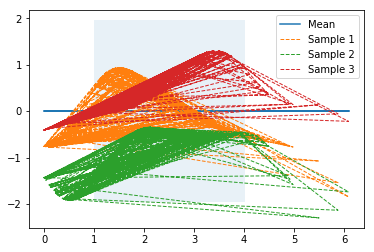

In [89]:
# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

In [106]:
# data
labeled_data = data[data.Label.notnull()].dropna()
unlabeled_data = data[data.Label.isnull()]

msk = np.random.rand(len(labeled_data)) < 0.8
train_data = labeled_data[msk]
test_data = labeled_data[~msk]

train_data = train_data
X_train = train_data[["Assisting and Caring for Others", "Persuasion", "Negotiation", "Social Perceptiveness",
"Fine Arts", "Originality", "Manual Dexterity", "Finger Dexterity", "Cramped Work Space, Awkward Positions"]].values
Y_train = train_data[["Label"]].values
test_data = test_data
X_test = test_data[["Assisting and Caring for Others", "Persuasion", "Negotiation", "Social Perceptiveness",
"Fine Arts", "Originality", "Manual Dexterity", "Finger Dexterity", "Cramped Work Space, Awkward Positions"]].values
Y_test = test_data[["Label"]].values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(54, 9)
(54, 1)
(13, 9)
(13, 1)


#### Gaussian classifier

$$ k(x_{i}, x_{j}) = \sigma^{2}_{f}exp(-\frac{1}{2l^2}(x_i - x_j)^T(x_i - x_j))$$

In [93]:
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

class GaussianClassifier:
    """
    Gaussian Classifier
    """
    def train(self, X, y):
        # class conditional classifier
        mask_0 = y == 0
        mask_1 = y == 1
        self.mean_0 = np.average(X[mask_0.ravel()], axis = 0)
        self.mean_1 = np.average(X[mask_1.ravel()], axis = 0)
        self.sigma_0 = np.cov(X[mask_0.ravel()], rowvar=False)
        self.sigma_1 = np.cov(X[mask_1.ravel()], rowvar=False)
        
        # class prior
        self.pi_0 = y[mask_0.ravel()].shape[0] / y.shape[0]
        self.pi_1 = 1.0 - self.pi_0
        
        # multivariate class-conditional density function
        self.prob_0 = multivariate_normal(self.mean_0, self.sigma_0, allow_singular=True)
        self.prob_1 = multivariate_normal(self.mean_1, self.sigma_0, allow_singular=True)
        
    def predict(self, X):
        preds = []
        for x_input in X:
            # class posterior (ignoring denominator in Bayes)
            if self.prob_0.pdf(x_input) * self.pi_0 > self.prob_1.pdf(x_input) * self.pi_1:
                preds.append(0)
            else:
                preds.append(1)
                
        return np.array(preds)
        
        

In [135]:
clf = GaussianClassifier()
clf.train(X_train, Y_train)

y_pred_test = clf.predict(X_test)

print("Final accuracy rate using all 9 features with the Gaussian Classifier is {}".format(accuracy_score(Y_test, y_pred_test)))

Final accuracy rate using all 9 features is 0.8461538461538461


#### Linear classifier

In [136]:
def calculate_parameters_and_errors(x_train, y_train, x_test, y_test):

    parameters = np.linalg.inv(np.dot(x_train.T, x_train)).dot(x_train.T).dot(y_train)
    Y_prediction = x_test.dot(parameters)
    Y_prediction = [1 if i>0.5 else 0 for i in Y_prediction ]
    error = y_test.reshape(-1) - Y_prediction
    error = np.absolute(error)
    percent_error = np.sum(error)/error.shape[0]
    accuracy = (1 - percent_error)
    return(accuracy, parameters)

accuracy, parameters = calculate_parameters_and_errors(X_train, Y_train, X_test, Y_test)
print("Final accuracy rate using all 9 features with the Linear Classifier is {}".format(accuracy))

Final accuracy rate using all 9 features with the Linear Classifier is 0.6923076923076923
